# Read in Essential Libraries

In [1]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read in Data

In [2]:
df = pd.read_excel("../input/boroughpop.xlsx")
df2 = pd.read_excel("../input/londonimddecile.xlsx")
df_map = pd.read_excel("../input/mmap.xlsx")

In [3]:
df.head()

,ladnm,population
0,Camden,253361
1,City of London,7654
2,Hackney,275929
3,Hammersmith and Fulham,182998
4,Haringey,271224


In [4]:
df2.head()

,lsoacode,lsoaname,ladcode,ladname,imddecile,gangpresent
0,E01000001,City of London 001A,E09000001,City of London,9,N
1,E01000002,City of London 001B,E09000001,City of London,9,N
2,E01000003,City of London 001C,E09000001,City of London,5,N
3,E01000005,City of London 001E,E09000001,City of London,4,N
4,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,4,N


In [5]:
df_map.head()

,ID,date,vicage,vicsex,vicethnic,susno,susage,sussex,weapon,Status,latitude,longitude,easting,northing,vicagegp,susagegp,catdom,catsyvage,lsoacode,ladnm
0,MM00001,2008-01-03,18,M,Black or Black British,NaN,NaN,NaN,Knife,Solved,51.61624,-0.06395,534139,192598,D. Teen 17-19,NaN,0,1,E01001432,Enfield
1,MM00002,2008-01-06,44,F,White or White British,NaN,NaN,NaN,Knife,Solved,51.45999,-0.13245,529840,175100,G. Adult 35-44,NaN,1,0,E01003057,Lambeth
2,MM00003,2008-01-07,18,M,Any Other Ethnic Appearance,NaN,NaN,NaN,Knife,Solved,51.47409,0.17896,551426,177266,D. Teen 17-19,NaN,0,1,E01000373,Bexley
3,MM00004,2008-01-08,58,M,White or White British,NaN,NaN,NaN,Blunt Object,Solved,51.58685,-0.27605,519533,188963,I. Adult 55-64,NaN,0,0,E01000591,Brent
4,MM00005,2008-01-13,25,M,Any Other Ethnic Appearance,NaN,NaN,NaN,Knife,Solved,51.46222,-0.11401,531115,175381,F. Adult 25-34,NaN,0,0,E01003047,Lambeth


# Merging Data

In [6]:
# Change name of column 'ladname' to 'ladnm' for merging data
df2 = df2.rename(columns={'ladname':'ladnm'})

In [7]:
# First merge (df and df2)
data = pd.merge(df,df2, on='ladnm',how='outer')

In [8]:
# Second merge (merged df,df2 and map data)
data = pd.merge(data,df_map, on=['ladnm','lsoacode'],how='outer')

In [9]:
# Overall information about merged data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5147 entries, 0 to 5146
Data columns (total 25 columns):
ladnm          5147 non-null object
population     5143 non-null float64
lsoacode       5147 non-null object
lsoaname       5143 non-null object
ladcode        5143 non-null object
imddecile      5143 non-null float64
gangpresent    5143 non-null object
ID             1328 non-null object
date           1328 non-null datetime64[ns]
vicage         1328 non-null float64
vicsex         1328 non-null object
vicethnic      1281 non-null object
susno          719 non-null float64
susage         712 non-null float64
sussex         715 non-null object
weapon         1328 non-null object
Status         1328 non-null object
latitude       1328 non-null float64
longitude      1328 non-null float64
easting        1328 non-null float64
northing       1328 non-null float64
vicagegp       1328 non-null object
susagegp       712 non-null object
catdom         1328 non-null float64
catsyvage      

In [10]:
# Look at first 5 rows of the merged data
data.head()

,ladnm,population,lsoacode,lsoaname,ladcode,imddecile,gangpresent,ID,date,vicage,vicsex,vicethnic,susno,susage,sussex,weapon,Status,latitude,longitude,easting,northing,vicagegp,susagegp,catdom,catsyvage
0,Camden,253361.0,E01000842,Camden 011A,E09000007,7.0,N,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Camden,253361.0,E01000843,Camden 014A,E09000007,5.0,N,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Camden,253361.0,E01000844,Camden 011B,E09000007,6.0,N,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Camden,253361.0,E01000845,Camden 014B,E09000007,7.0,N,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Camden,253361.0,E01000846,Camden 014C,E09000007,4.0,N,MM01229,2018-02-09,55.0,F,White or White British,2.0,43.0,F,Knife,Awaiting Outcome,51.54417,-0.16594,527279.0,184402.0,I. Adult 55-64,G. Adult 35-44,0.0,0.0


# Missing Data

The missingno package allows us to visualize how many missing values we have for each variable!

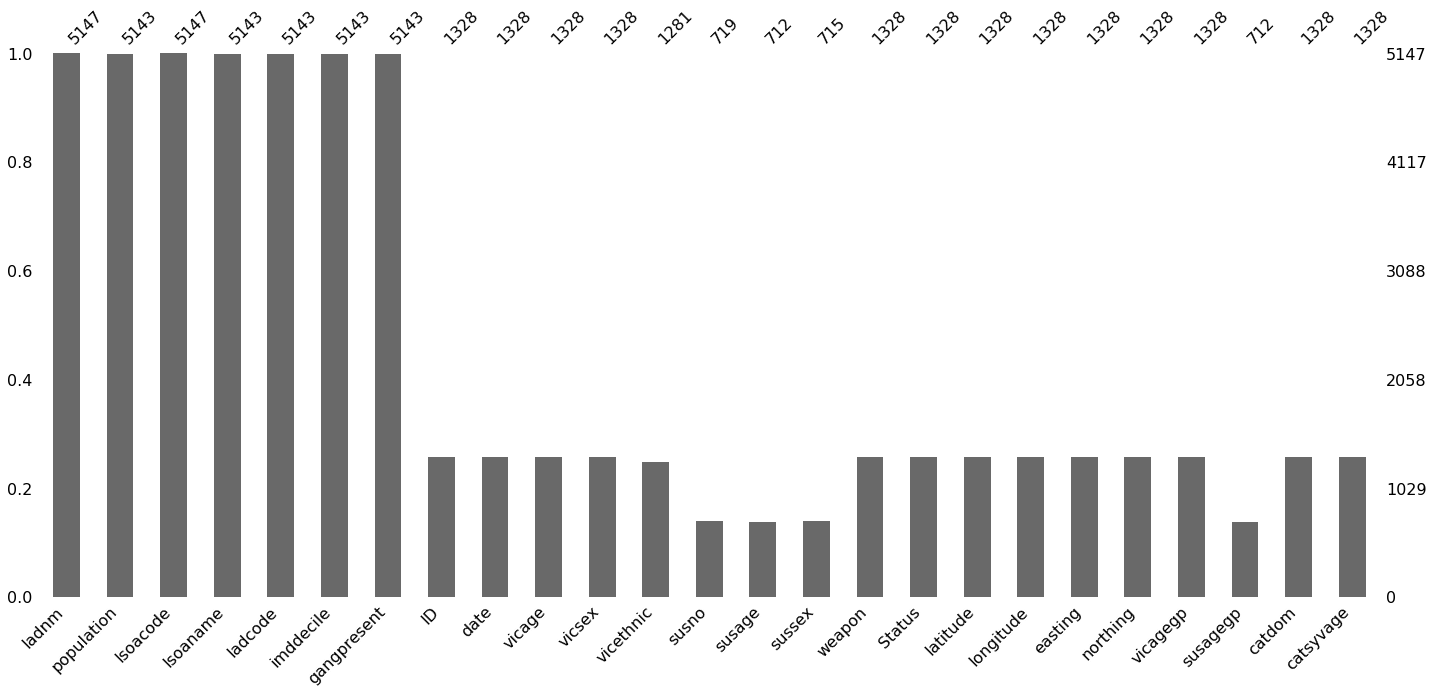

In [11]:
msno.bar(data)

# Univariate EDA

###### Population of each Borough

In [12]:
# Number of unique boroughs in London
data.ladnm.nunique()

33

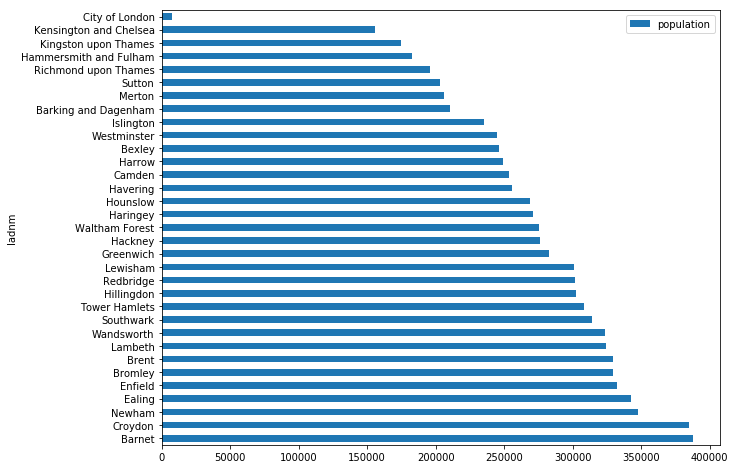

In [13]:
df.sort_values('population', ascending=False).set_index('ladnm').plot.barh(figsize=(10,8))

###### Index of Deprivation(imd decile)

https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/579151/English_Indices_of_Deprivation_2015_-_Frequently_Asked_Questions_Dec_2016.pdf

The Index of Multiple Deprivation, commonly known as the IMD, is the official measure of relative deprivation for small areas in England. The Index of Multiple Deprivation ranks every small area in England from 1 (mostdeprived area) to 32,844 (least deprived area). The Index of Multiple Deprivation (IMD) combines information from the seven domains to produce an overall relative measure of deprivation. Those domains include income deprivation, employment deprivation, barriers to housing etc.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


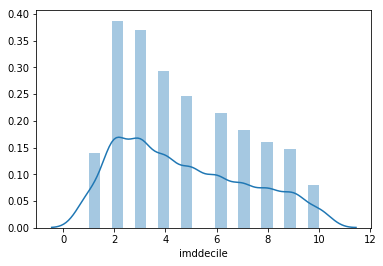

In [14]:
# Distribution of Index of Multiple Deprivation
sns.distplot(data[data.imddecile.notnull()].imddecile)

But the variable "imddecile" is given in deciles and there is no additional information about whether the higher deciles (closer to 12) represent more deprived areas or not, so unsure how to interpret this variable for now!

###### Where Gang is Present in a certain Borough (Binary variable: Yes or No) 

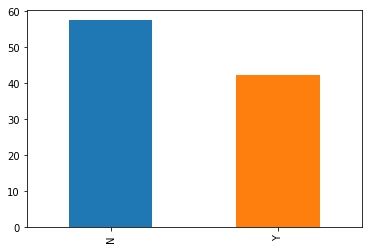

In [15]:
# Proportion of boroughs where gangs are present (In Orange)
(data.groupby('ladnm').first().gangpresent.value_counts()*100 / data.groupby('ladnm').first().gangpresent.value_counts().sum()).plot('bar')

London has slightly more (about 57%) boroughs that don't have gangs. But is this proportion statistically significant? We can use the Chi-Squared test of goodness-of-fit to check this.

In [16]:
# Chi-Squared test of goodness-of-fit 
from scipy import stats
stats.chisquare(f_obs= data.groupby('ladnm').first().gangpresent.value_counts()*100 / data.groupby('ladnm').first().gangpresent.\
                value_counts().sum(),
                f_exp= [0.5,0.5])

Power_divergenceResult(statistic=10030.568411386594, pvalue=0.0)

The p-value is smaller than 0.05 which is the typical significance level for statistical significance and thus **London has statistically higher proportion of boroughs that don't have gangs.**

###### Age distribution of victims and suspects

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


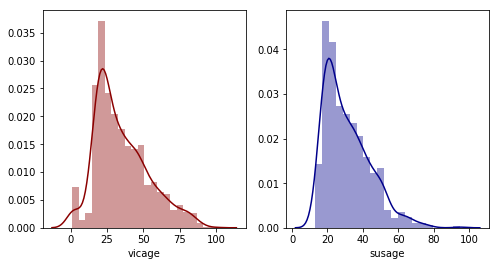

In [17]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax1 = sns.distplot(data[data.vicage.notnull()].vicage,ax=axes[0],color='darkred')
ax2 = sns.distplot(data[data.susage.notnull()].susage,ax=axes[1],color='darkblue')

###### Sex proportions of victims and suspects

([<matplotlib.patches.Wedge at 0x7f5fcbf74358>,
 [Text(0.322217,-1.05175,'Male'), Text(-0.322217,1.05175,'Female')],
 [Text(0.175755,-0.573681,'76.1%'), Text(-0.175755,0.573681,'23.9%')])

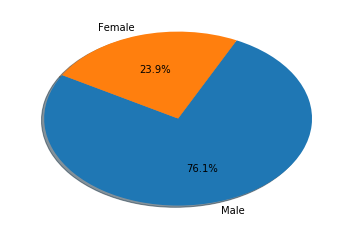

In [18]:
# Victim sex proportion
labels='Male','Female'
plt.pie(data['vicsex'].value_counts(), labels=labels,autopct='%1.1f%%', startangle = 150, shadow=True)

([<matplotlib.patches.Wedge at 0x7f5fcbe30978>,
 [Text(0.796663,-0.758504,'Male'), Text(-0.796663,0.758504,'Female')],
 [Text(0.434544,-0.413729,'92.4%'), Text(-0.434544,0.413729,'7.6%')])

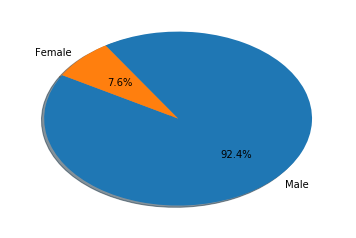

In [19]:
# Suspect sex proportion
labels='Male','Female'
plt.pie(data['sussex'].value_counts(), labels=labels,autopct='%1.1f%%', startangle = 150,shadow=True)

The proportion of males is higher suspects than victims (92.4% > 76.1%)

###### Types of weapons used

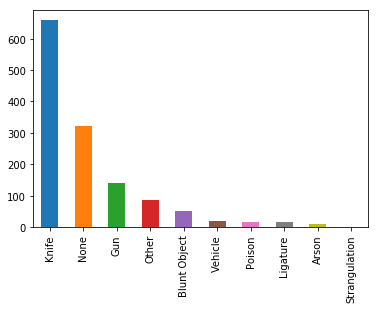

In [20]:
data.weapon.value_counts().plot('bar')

I guess knife is the most commonplace weapon people can easily access to kill people

Text(0.5,1,'% proportion homicide cases by Status')

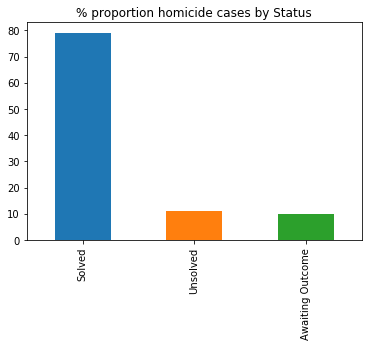

In [21]:
(data.Status.value_counts() * 100 / data.Status.value_counts().sum()).plot('bar')
plt.title("% proportion homicide cases by Status")

# Bivariate & Multivariate EDA

We first extract year and month information from the date column and make them into sepearate columns for convenience

In [22]:
data['date_year'] = data.date.dt.year
data['date_month'] = data.date.dt.month

###### How has the total number of homicides change over time (year and month)

Text(0.5,1,'Number of homicides in London over time')

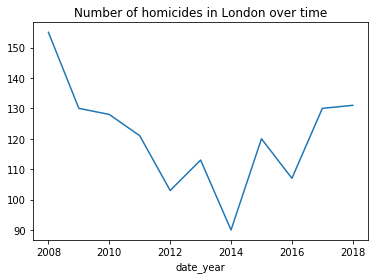

In [23]:
data.groupby('date_year').size().plot()
plt.title("Number of homicides in London over time")

The total number of homicides was on the decreasing trend until 2014 but it has been increasing again ever since!

Text(0.5,1,'Number of homocides by month')

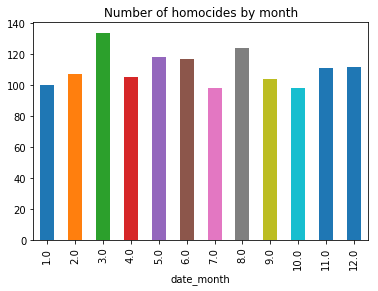

In [24]:
data.groupby('date_month').size().plot('bar')
plt.title("Number of homocides by month")

###### Which weapons are male suspects more likely to use than female suspects?

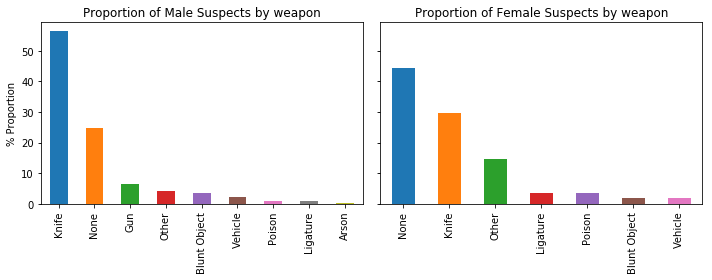

In [25]:
f, axes = plt.subplots(1,2, figsize=(10,4),sharey=True)

ax1 = (data[data.sussex=='M'].weapon.value_counts() * 100 / data[data.sussex=='M'].weapon.value_counts().sum()).plot('bar', ax=axes[0])
ax1.set_ylabel("% Proportion")
ax1.set_title("Proportion of Male Suspects by weapon")

ax2 = (data[data.sussex=='F'].weapon.value_counts() * 100 / data[data.sussex=='F'].weapon.value_counts().sum()).plot('bar', ax=axes[1])
ax2.set_ylabel("% Proportion")
ax2.set_title("Proportion of Female Suspects by weapon")
plt.tight_layout()

From the observed data, we see that knives and guns are common weapons of choie for male suspects while non-traditional ways of homicide that don't require weapons (as indicated by "None", "Other", "Poison") are preferred by female suspects. But is this difference statistically significant? We can use the Chi Squared Test of Indepence for this!

In [26]:
from scipy.stats import chi2_contingency
table = pd.crosstab(data.sussex, data.weapon)
stat, p, dof, expected = chi2_contingency(table)
print("p-value: ",p) 

p-value:  1.69780966404067e-05


The p-value is smaller than 0.05 and thus suspect's sex and the choice of weapon are not independent. They are correlated! Male suspects are more likely to use some form of weapon most likely because of their stronger physical strength.

###### Is there a statistically significant difference in average number of homicides in which victims were females between gang present and non-present boroughs?

In [27]:
# Add information about number of homicides in which victims were females to the original dataframe
data = data.merge(pd.DataFrame(data[data.vicsex=='F'].groupby('ladnm').size(),columns=['num_of_female_vic_cases']).reset_index(),
           how='left',on=['ladnm'])

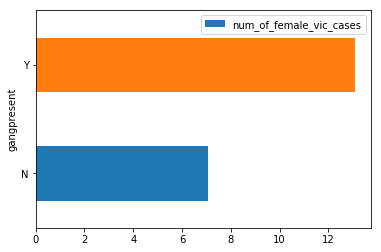

In [28]:
# Number of homicides in which victims were females by gang present status
data.groupby('ladnm').first().groupby('gangpresent').mean().\
reset_index().plot(y='num_of_female_vic_cases',x= 'gangpresent', kind='barh')

In [29]:
# Variance of Number of homicides in which victims were females in gang present boroughs
data.groupby('ladnm').first().groupby('gangpresent').get_group('Y').num_of_female_vic_cases.var()

12.994505494505496

In [30]:
# Variance of Number of homicides in which victims were females in gang non-present boroughs
data.groupby('ladnm').first().groupby('gangpresent').get_group('N').num_of_female_vic_cases.var()

18.60818713450292

Boroughs where gangs are present have more cases of homicide cases where victims were females. Is this statistically significant? We can use the independent two sample t-test with non-equal variance(we just checked above that the variances of the two groups are different) to test this!

In [31]:
from scipy.stats import ttest_ind
d1,d2 = data.groupby('ladnm').first().groupby('gangpresent').get_group('Y').num_of_female_vic_cases,\
data.groupby('ladnm').first().groupby('gangpresent').get_group('N').num_of_female_vic_cases

ttest_ind(d1,d2, equal_var=False)

Ttest_indResult(statistic=4.357836244411526, pvalue=0.0001381926476623015)

p-value is smaller than 0.05 and thus it is statistically significant! Thus, boroughs with gangs have significantly more cases of homicide where victims were females!

###### Victim Profile

In [32]:
# Chi Squared Test of Indepenence on Victims' ethnicity and sex
chi2_contingency(pd.crosstab(data.vicethnic, data.vicsex))

(67.00786453968855,
 1.865400421831358e-14,
 3,
 array([[ 22.95081967,  75.04918033],
        [ 35.5971897 , 116.4028103 ],
        [110.30444965, 360.69555035],
        [131.14754098, 428.85245902]]))

P-value is 1.865400421831358e-14 < 0.05 and thus there is statistically significant correlation between victims' ethnicity and age. We can perform 2x2 post-hoc tests to find out which category is correlated to which category

In [33]:
data2 = data.copy() # Make a copy of data just for this test
data2 = data2.join(pd.get_dummies(data2.vicethnic)) # Join the dummy variables onto the original dataframe

In [34]:
# Chi Squared test of indepence on relationship between victims having any other ethnic appearance and their sex
chi2_contingency(pd.crosstab(data2['Any Other Ethnic Appearance'], data2.vicsex))

(0.9188350558966525,
 0.33778103455781167,
 1,
 array([[293.60692771, 936.39307229],
        [ 23.39307229,  74.60692771]]))

In [35]:
# Chi Squared test of indepence on relationship between victims being White or White British and their sex
chi2_contingency(pd.crosstab(data2['White or White British'], data2.vicsex))

(18.308467775306845,
 1.8787023692741848e-05,
 1,
 array([[183.3253012, 584.6746988],
        [133.6746988, 426.3253012]]))

In [36]:
# Chi Squared test of indepence on relationship between victims being Black or Black British and their sex
chi2_contingency(pd.crosstab(data2['Black or Black British'], data2.vicsex))

(56.63321922726436,
 5.251711187464129e-14,
 1,
 array([[204.57003012, 652.42996988],
        [112.42996988, 358.57003012]]))

In [37]:
# Chi Squared test of indepence on relationship between victims being Asian or Asian British and their sex
chi2_contingency(pd.crosstab(data2['Asian or Asian British'], data2.vicsex))

(18.40328809206807,
 1.787492652859543e-05,
 1,
 array([[280.71686747, 895.28313253],
        [ 36.28313253, 115.71686747]]))

In [38]:
# Percentage Proportion normalized by row
pd.crosstab(data.vicethnic, data.vicsex,normalize='index')

vicsex,F,M
vicethnic,,
Any Other Ethnic Appearance,0.193878,0.806122
Asian or Asian British,0.381579,0.618421
Black or Black British,0.118896,0.881104
White or White British,0.298214,0.701786


Asian females had higher risk of being killed than females of other races. Black men had higher risk of being killed than men of other racces. 

###### What are some variables that are statistically significant with "Status"(Whether cases are resolved or unsolved etc.)

In [39]:
# Chi Squared Test of Indepenence on suspects' sex and status
chi2_contingency(pd.crosstab(data.sussex, data.Status))

(0.10476622675130716,
 0.9489652359164915,
 2,
 array([[  8.23216783,  42.52027972,   3.24755245],
        [100.76783217, 520.47972028,  39.75244755]]))

Suspects' sex is not much correlated with the case Status (statistically insignificant)

In [40]:
# Chi Squared Test of Indepenence on choice of weapons and status
chi2_contingency(pd.crosstab(data.weapon, data.Status))

(170.23495047257026,
 8.144747571246797e-27,
 18,
 array([[9.71385542e-01, 7.90662651e+00, 1.12198795e+00],
        [5.14834337e+00, 4.19051205e+01, 5.94653614e+00],
        [1.35993976e+01, 1.10692771e+02, 1.57078313e+01],
        [6.40143072e+01, 5.21046687e+02, 7.39390060e+01],
        [1.45707831e+00, 1.18599398e+01, 1.68298193e+00],
        [3.13757530e+01, 2.55384036e+02, 3.62402108e+01],
        [8.45105422e+00, 6.87876506e+01, 9.76129518e+00],
        [1.74849398e+00, 1.42319277e+01, 2.01957831e+00],
        [1.94277108e-01, 1.58132530e+00, 2.24397590e-01],
        [2.03990964e+00, 1.66039157e+01, 2.35617470e+00]]))

In [41]:
pd.crosstab(data.weapon, data.Status, normalize='columns')

Status,Awaiting Outcome,Solved,Unsolved
weapon,,,
Arson,0.015504,0.007619,0.000000
Blunt Object,0.031008,0.044762,0.013423
Gun,0.093023,0.067619,0.382550
Knife,0.565891,0.512381,0.322148
Ligature,0.000000,0.013333,0.006711
None,0.255814,0.248571,0.194631
Other,0.031008,0.069524,0.067114
Poison,0.007752,0.016190,0.000000
Strangulation,0.000000,0.000000,0.013423


Choice of weapons and case status is correlated but need to perform post-hoc chi squared tests on every single weapon. We skip this for now. But the table above shows that 51% among all solved cases were homicides that involved knives and 38% among all unsolves cases were homicides that involved guns.

In [42]:
# Chi Squared Test of Indepenence on victims' ethnicity and status
chi2_contingency(pd.crosstab(data.vicethnic, data.Status))

(36.65092878193743,
 2.059411419505077e-06,
 6,
 array([[  8.79781421,  78.03278689,  11.16939891],
        [ 13.64558938, 121.03044496,  17.32396565],
        [ 42.28337237, 375.03512881,  53.68149883],
        [ 50.27322404, 445.90163934,  63.82513661]]))

In [43]:
pd.crosstab(data.vicethnic, data.Status,normalize='index')

Status,Awaiting Outcome,Solved,Unsolved
vicethnic,,,
Any Other Ethnic Appearance,0.051020,0.806122,0.142857
Asian or Asian British,0.092105,0.815789,0.092105
Black or Black British,0.127389,0.713376,0.159236
White or White British,0.064286,0.858929,0.076786


If the victim was Black, it is more likely that the case has been unsolved compared to other cases regarding White victims. If the victim was White, it is more likely that the case has been solved compared to other cases regarding victims of color. Some evidence of ethnic bias?

In [44]:
# Chi Squared Test of Indepenence on Victims' sex and status
chi2_contingency(pd.crosstab(data.vicsex, data.Status))

(15.968735309016877,
 0.00034074789856006535,
 2,
 array([[ 30.79292169, 250.64006024,  35.56701807],
        [ 98.20707831, 799.35993976, 113.43298193]]))

In [45]:
pd.crosstab(data.vicsex, data.Status, normalize='index')

Status,Awaiting Outcome,Solved,Unsolved
vicsex,,,
F,0.100946,0.848580,0.050473
M,0.095945,0.772502,0.131553


If the victim was a man, it is less likely that the case was solved

###### Geospatial patterns of victim profile

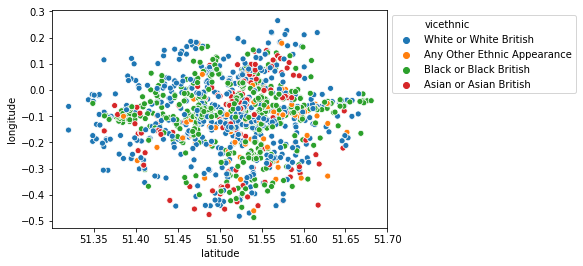

In [46]:
# Victims' ethnicity in various boroughs(location)
sns.scatterplot(x='latitude',y='longitude',data=data,hue='vicethnic')
plt.legend(loc='best', bbox_to_anchor=(1,1))

The scatter plot above suggests that White victims(blue dots) were killed in broader regions across London while Asian(red dots) or Black(Green dots) victims were mainly killed in central regions (less variance)

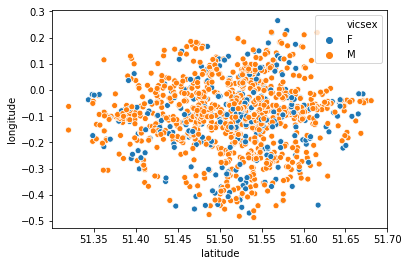

In [47]:
# Victims' sex in various boroughs(location)
sns.scatterplot(x='latitude',y='longitude',data=data,hue='vicsex')
plt.legend(loc=1)

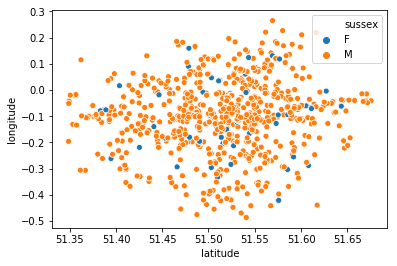

In [48]:
# Suspects' sex in various boroughs(location)
sns.scatterplot(x='latitude',y='longitude',data=data,hue='sussex')

###### Relationship amongst population, IMD Decile and number of cases where victims were females of boroughs

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


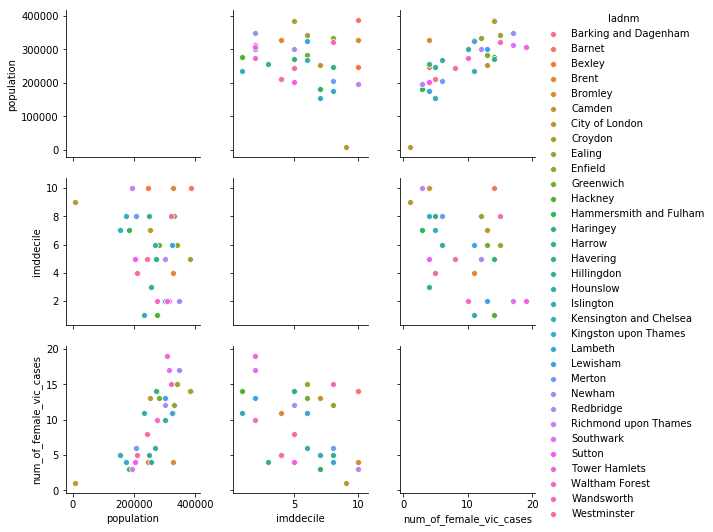

In [49]:
sns.pairplot(data.groupby('ladnm').first().reset_index(), vars=['population','imddecile','num_of_female_vic_cases'], hue='ladnm')

Boroughs with bigger population are more likely to have higher number of homicide cases where victims are females. I guess this this natural because if the population is bigger, more people are exposed to crimes like homicide. Also, IMD decile and the number of homicide cases where victims are females also has some correlation although the strength of the correlation doesn't seem to be that strong. The higher the IMD decile (presumably, the more deprived a certain borough is... need more info on this variable), the lower the number of homicide cases where victims are females.

### Thank you for reading my kernel! If you liked my kernel, please upvote it! Happy new year and happy Kaggling! :)